<a href="https://colab.research.google.com/github/Nichiel/rubbish_classifier/blob/main/training_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall tensorflow
!pip install  tensorflow==2.1.0

In [ ]:
!pip install h5py==2.10.0 --force-reinstall

In [ ]:
import tensorflow
tensorflow.__version__

'2.1.0'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pathlib

from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout


In [ ]:
folder_name = ['P','TP']
IMG_SIZE = (224,224)
batch_size = 32
base_learning_rate = 0.001
IMG_SHAPE = (224,224) + (3,)


In [ ]:
def PhotoImport(folder_name):
  file_list = []
  for index in folder_name:
    imgdir_path = pathlib.Path('drive/MyDrive/PHOTO_AU/', index )
    last_list = sorted([str(path) for path in imgdir_path.glob('*.png')]) 
    file_list += last_list
  
  return file_list, [1 if 'TP' in file else 0 for file in file_list]

In [ ]:
def load_and_preprocess(path, label):
    image = tf.io.read_file(path) 
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    
    return (image/255.0, tf.cast(label, tf.int32))

In [ ]:
file_list, labels = PhotoImport(folder_name)
ds_files_labels = tf.data.Dataset.from_tensor_slices((file_list, labels))

ds_files_labels = ds_files_labels.shuffle(len(file_list), reshuffle_each_iteration=False)

bin_files_valid = ds_files_labels.take(673)
bin_files_train = ds_files_labels.skip(673)
ds_bin_train = bin_files_train.map(load_and_preprocess)
ds_bin_valid = bin_files_valid.map(load_and_preprocess)
ds_bin_train = ds_bin_train.batch(batch_size)
ds_bin_valid = ds_bin_valid.batch(batch_size)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_bin_train = ds_bin_train.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
base_model = ResNet101V2(input_shape= IMG_SHAPE, include_top=True, weights='imagenet')


In [ ]:
transfer_layer = base_model.get_layer('avg_pool')
transfer_layer.output

conv_model = Model(inputs=base_model.input, outputs=transfer_layer.output)
new_model = Sequential()
new_model.add(conv_model)
new_model.add(Dense(1024, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(1, activation='sigmoid'))


In [ ]:
conv_model.trainable = True
for layer in conv_model.layers[:]:
    trainable_layer = ('conv5' in layer.name)
    layer.trainable = trainable_layer


In [ ]:
loss_function=tf.keras.losses.BinaryCrossentropy( from_logits= True)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
metrics=['accuracy']
total_epochs =  15
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights = True)

new_model.compile(loss=loss_function, optimizer = optimizer,  metrics=metrics)

In [ ]:
history_fine = new_model.fit(x = ds_bin_train, 
                         epochs=total_epochs,
                         validation_data=ds_bin_valid, callbacks=[callback])

Train for 354 steps, validate for 22 steps
Epoch 1/15
354/354 [==============================] - 96s 272ms/step - loss: 0.5263 - accuracy: 0.9765 - val_loss: 0.5345 - val_accuracy: 0.9941
Epoch 2/15
354/354 [==============================] - 77s 216ms/step - loss: 0.5153 - accuracy: 0.9960 - val_loss: 0.5329 - val_accuracy: 0.9941
Epoch 3/15
354/354 [==============================] - 77s 217ms/step - loss: 0.5139 - accuracy: 0.9986 - val_loss: 0.5338 - val_accuracy: 0.9926
Epoch 4/15
354/354 [==============================] - 77s 218ms/step - loss: 0.5145 - accuracy: 0.9979 - val_loss: 0.5337 - val_accuracy: 0.9926
Epoch 5/15
354/354 [==============================] - 78s 219ms/step - loss: 0.5142 - accuracy: 0.9981 - val_loss: 0.5402 - val_accuracy: 0.9747
Epoch 6/15
354/354 [==============================] - 78s 220ms/step - loss: 0.5143 - accuracy: 0.9981 - val_loss: 0.5363 - val_accuracy: 0.9881


In [ ]:
new_model.save( 'drive/MyDrive/rubbish_classifier_model_A_0001.h5', overwrite = True, include_optimizer = True, save_format = 'h5')

In [ ]:
history = history_fine

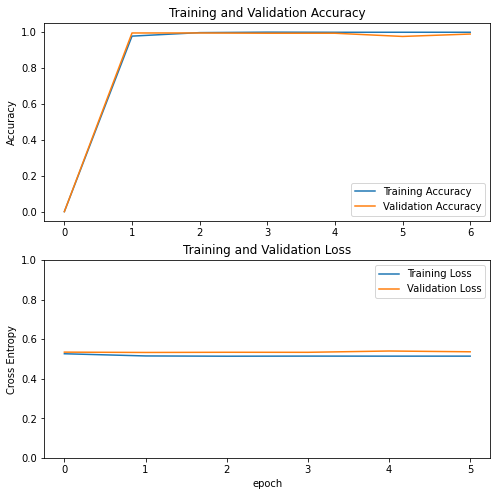

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1.05])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()